In [4]:
#import
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [3]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True
)

In [5]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [6]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))
train_ds[0].shape

TensorShape([150, 150, 3])

In [7]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=train_ds[0].shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
## We will not train base model i.e. Freeze Parameters in model's lower convolutional layers
base_model.trainable = False
## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)
## model details
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model, flatten_layer, dense_layer_1, dense_layer_2, prediction_layer
])


In [13]:
#Train classifier layers on training data available for task
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.4026 - loss: 3.0931 - val_accuracy: 0.6226 - val_loss: 1.0566
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 621s 9s/step - accuracy: 0.7470 - loss: 0.6935 - val_accuracy: 0.6673 - val_loss: 1.0340
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 581s 9s/step - accuracy: 0.8296 - loss: 0.4695 - val_accuracy: 0.6848 - val_loss: 0.9973
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 582s 9s/step - accuracy: 0.8618 - loss: 0.3680 - val_accuracy: 0.6907 - val_loss: 0.9689
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 543s 8s/step - accuracy: 0.9337 - loss: 0.2186 - val_accuracy: 0.6965 - val_loss: 1.0381
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 593s 9s/step - accuracy: 0.9565 - loss: 0.1449 - val_accuracy: 0.6984 - val_loss: 1.0834
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 540s 8s/step - accuracy: 0.9691 - loss: 0.1146 - val_accuracy: 0.6946 - val_loss: 1.1375
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 561s 8s/step - accuracy: 0.9706 - loss: 0.0966 - val_accuracy: 0.7121 - v

In [14]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.9962 - loss: 0.0275
Loss:  0.023890890181064606 Accuracy:  0.9981834888458252


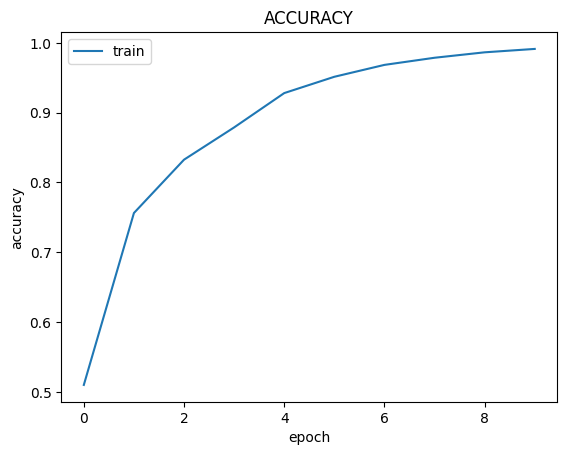

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
